In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pylab

Matplotlib is building the font cache; this may take a moment.


In [10]:
batch_size=256
img_size=(224,224)

train_ds = keras.utils.image_dataset_from_directory(
    'datasets/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
)
val_ds = keras.utils.image_dataset_from_directory(
    'datasets/val',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


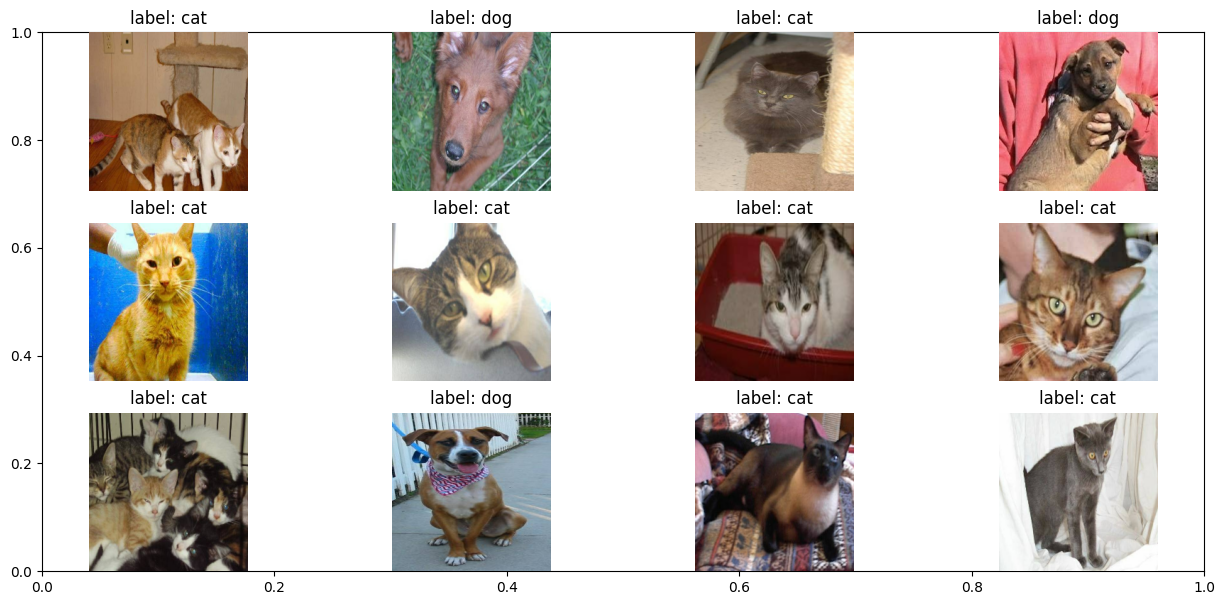

In [11]:
label_names = {0: 'cat', 1: 'dog'}

# Displaying images with labels
fig, ax = plt.subplots(figsize=(15, 7))
for img, label in train_ds.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(img.numpy()[i] / 255)
        plt.axis("off")
        plt.title("label: " + label_names[label.numpy()[i]])
plt.show()

## Load Model

### Plot Display

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_history(history,title=''):  
    if title!='':
        title+=' '
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    #Loss
    sns.lineplot(data = history.history['loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history.history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title(title+'Loss')
    #Accuracy
    sns.lineplot(data = history.history['accuracy'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history.history['val_accuracy'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title(title+'Accuracy')

### Augmentation

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(0.14,0.14),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ]
)

### Call back

In [15]:
CB = [
            keras.callbacks.ModelCheckpoint(
            filepath="fine_tuning.keras",
            save_best_only=True,
            monitor="val_loss"),
    
            keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0005,
            patience=10)
]

### Vgg16

In [16]:
vgg16_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    #weights=None,
    include_top=False)

#vgg16_base.trainable = True
vgg16_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg16_base.trainable_weights))

vgg16_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
This is the number of trainable weights before freezing the conv base: 0


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg16_base(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg16_model = keras.Model(inputs, outputs)
vgg16_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 25088)     │    100,352 │ flatten[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  6,422,784 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,439,810 (81.79 MB)

 Trainable params: 6,672,898 (25.46 MB)

 Non-trainable params: 14,766,912 (56.33 MB)

In [18]:
history_vgg16 = vgg16_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=CB
    )
vgg16_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4984s 63s/step - accuracy: 0.8118 - loss: 0.4900 - val_accuracy: 0.9810 - val_loss: 0.0831
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4946s 63s/step - accuracy: 0.9336 - loss: 0.1619 - val_accuracy: 0.9842 - val_loss: 0.0547
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4835s 61s/step - accuracy: 0.9407 - loss: 0.1463 - val_accuracy: 0.9854 - val_loss: 0.0452
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4809s 61s/step - accuracy: 0.9486 - loss: 0.1377 - val_accuracy: 0.9862 - val_loss: 0.0407
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4758s 60s/step - accuracy: 0.9545 - loss: 0.1206 - val_accuracy: 0.9876 - val_loss: 0.0376
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4789s 61s/step - accuracy: 0.9540 - loss: 0.1185 - val_accuracy: 0.9866 - val_loss: 0.0369
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4778s 61s/step - accuracy: 0.9526 - loss: 0.1192 - val_accuracy: 0.9868 - val_loss: 0.0358
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4756s 60s/step - accuracy: 0.9524 - loss: 0.1161 - val_accu

In [20]:
vgg16_model.save('vgg16.keras')

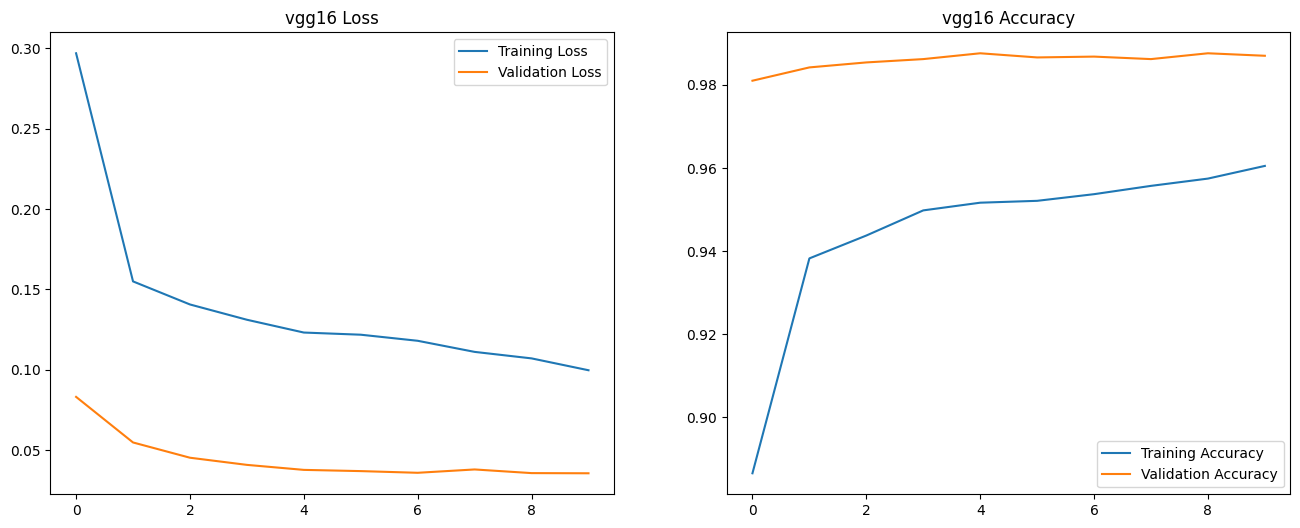

In [19]:
plot_history(history_vgg16,'vgg16')

### Load Test

In [21]:
import os
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets/test",
    labels=None,
    shuffle=False,
    batch_size=batch_size,
    image_size=img_size
)

Found 500 files.


In [22]:
file_paths = test_ds.file_paths

In [23]:
predictions = vgg16_model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1) #class of image
#id column based
ids = np.arange(1, len(predicted_labels) + 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 94s 46s/step
